In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.utils import resample
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset 
from tqdm import tqdm
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

Read the data

In [45]:
df = pd.read_csv('bot_iot.csv')
df.shape

C:\Users\009kr\AppData\Local\Temp\ipykernel_15172\3036118028.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bot_iot.csv')


(668522, 46)

In [46]:
df.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,3000001,1.528099e+09,e,1,udp,3,192.168.100.147,6226,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
1,3000002,1.528099e+09,e,1,udp,3,192.168.100.147,6227,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
2,3000003,1.528099e+09,e,1,udp,3,192.168.100.147,6228,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
3,3000004,1.528099e+09,e,1,udp,3,192.168.100.147,6229,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
4,3000005,1.528099e+09,e,1,udp,3,192.168.100.147,6230,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP


In [47]:
df.category.unique()

array(['DDoS', 'Normal', 'Reconnaissance', 'Theft'], dtype=object)

In [48]:
df['category'] = df['category'].apply(lambda x: x if x in ['DDoS'] else 'Other')

In [49]:
#label encode the output column
category_map = {'DDoS':0, 'Other':1}
df['category'] = df['category'].replace(category_map)

C:\Users\009kr\AppData\Local\Temp\ipykernel_15172\355839375.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'] = df['category'].replace(category_map)


In [50]:
df.category.value_counts()

category
0    576884
1     91638
Name: count, dtype: int64

In [51]:
df.pkSeqID.unique().size

668522

Check information regarding the features

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

In [53]:
df['Pkts_P_State_P_Protocol_P_SrcIP'] == df['AR_P_Proto_P_SrcIP']

0         False
1         False
2         False
3         False
4         False
          ...  
668517    False
668518    False
668519    False
668520    False
668521    False
Length: 668522, dtype: bool

Data Preprocessing

In [54]:
df.flgs.unique()

array(['e', 'eU', 'e &', 'e d', 'e   t', 'e s', 'e  D', 'e *', 'e g'],
      dtype=object)

In [55]:
#Features not useful
df = df.drop(['flgs','flgs_number'], axis = 1)

In [56]:
df.proto.unique()

array(['udp', 'arp', 'icmp', 'tcp', 'ipv6-icmp'], dtype=object)

In [57]:
#Similar feature exists in numeric format
df = df.drop(['proto'],axis=1)

In [58]:
df.proto_number.unique()

array([3, 2, 4, 1, 5], dtype=int64)

In [59]:
df.saddr.unique()

array(['192.168.100.147', '192.168.100.148', '192.168.100.149',
       '192.168.100.150', '192.168.100.3', '192.168.100.1',
       '192.168.100.7', '192.168.100.4', '192.168.100.27',
       'fe80::250:56ff:febe:254', '192.168.100.46', '192.168.100.6',
       '192.168.100.5', 'fe80::250:56ff:febe:26db',
       'fe80::250:56ff:febe:e9d9', 'fe80::c0c0:aa20:45b9:bdd9',
       'fe80::250:56ff:febe:89ee', 'fe80::2c6a:ff9b:7e14:166a',
       'fe80::250:56ff:febe:bf1a', 'fe80::250:56ff:febe:c038',
       '192.168.100.55'], dtype=object)

In [60]:
#Convert ip/mac addresses to a more useable format
def conv_ip_addr(ip_addr):
    ip_addr = ip_addr.replace(':','.')
    temp = ip_addr.split('.')
    op = ''.join(temp)
    if op.isnumeric():
        op = int(op)
    else:
        op =int(op, 16)
    return op

In [61]:
df.saddr.dtype

dtype('O')

In [62]:
df['saddr'] = df['saddr'].apply(conv_ip_addr)

In [63]:
df['saddr'] = pd.to_numeric(df['saddr'], errors = 'coerce')

In [64]:
df['daddr'] = df['daddr'].apply(conv_ip_addr)

In [65]:
#Unable to find a better way to handle port addresses might change this
df = df.drop(['dport','sport'],axis=1)

In [66]:
df.state.unique()

array(['INT', 'CON', 'URP', 'FIN', 'NRS', 'RST', 'ECO', 'TST', 'MAS',
       'REQ'], dtype=object)

In [67]:
#One hot encode state feature, might be important
df = pd.get_dummies(df, columns=['state'], prefix=['state'])

In [68]:
df = df.drop(['state_number'],axis=1)

In [69]:
df.attack.unique()

array([1, 0], dtype=int64)

In [70]:
df = df.drop(['pkSeqID','attack','subcategory'], axis=1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   stime                             668522 non-null  float64
 1   proto_number                      668522 non-null  int64  
 2   saddr                             668522 non-null  float64
 3   daddr                             668522 non-null  int64  
 4   pkts                              668522 non-null  int64  
 5   bytes                             668522 non-null  int64  
 6   ltime                             668522 non-null  float64
 7   seq                               668522 non-null  int64  
 8   dur                               668522 non-null  float64
 9   mean                              668522 non-null  float64
 10  stddev                            668522 non-null  float64
 11  sum                               668522 non-null  f

CNN without Feature selection

In [72]:
col_to_scale = ['stime','saddr','daddr', 'pkts', 'bytes', 'ltime', 'dur', 
                'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
                'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
                'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
                'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP']

In [73]:
m = []
s = []

for col in col_to_scale:
    mu = df[col].mean()
    m.append(mu)
    stdd = df[col].std()
    s.append(stdd)

    df[col] = (df[col]-mu)/stdd

In [74]:
df.columns

Index(['stime', 'proto_number', 'saddr', 'daddr', 'pkts', 'bytes', 'ltime',
       'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_MAS', 'state_NRS', 'state_REQ', 'state_RST', 'state_TST',
       'state_URP'],
      dtype='object')

In [75]:
cols_to_conv = ['state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_MAS', 'state_NRS', 'state_REQ', 'state_RST', 'state_TST',
       'state_URP']

df[cols_to_conv] = df[cols_to_conv].astype(int)

In [76]:
indices_to_remove = df[df['category'] == 0].index

# Randomly select 106 indices from those
indices_to_remove = np.random.choice(indices_to_remove, size=106, replace=False)

# Remove the selected rows from the DataFrame
df = df.drop(indices_to_remove)

In [77]:
X = df.drop(['category'],axis=1)
y = df['category']

In [78]:
df.head()

,stime,proto_number,saddr,daddr,pkts,bytes,ltime,seq,dur,mean,...,state_CON,state_ECO,state_FIN,state_INT,state_MAS,state_NRS,state_REQ,state_RST,state_TST,state_URP
0,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109223,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
1,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109224,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
2,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109225,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
3,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109226,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
4,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109227,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0


In [79]:
X = df.drop(['category'], axis=1)
y = df['category']

In [38]:
xtrain, xtest, ytrain, ytest = tts(X,y,test_size=0.2,random_state=42)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
device

device(type='cuda')

In [35]:
xtrain = torch.FloatTensor(xtrain.values).unsqueeze(1)
ytrain = torch.LongTensor(ytrain.values)
xtest = torch.FloatTensor(xtest.values).unsqueeze(1)
ytest = torch.LongTensor(ytest.values)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
xtrain, xtest, ytrain, ytest = xtrain.to(device), xtest.to(device),ytrain.to(device), ytest.to(device)

In [ ]:
#xtrain, xtest = xtrain.reshape(-1,1,45), xtest.reshape(-1,1,45)

In [ ]:
xtrain.shape

torch.Size([16000, 1, 45])

In [ ]:
train_dataset = TensorDataset(xtrain, ytrain)

In [44]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

NameError: name 'train_dataset' is not defined

In [45]:
num_epochs = 21
learning_rate = 0.001

In [46]:
class PrintShape(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [47]:
df.shape

(668522, 46)

In [82]:
class Multiclass(nn.Module):
    def __init__(self):
        super(Multiclass, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3, stride=1, padding=1),
        #PrintShape(),
        nn.BatchNorm1d(15),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv1d(in_channels=15, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(32),
       # pool2 = nn.MaxPool1d(kernel_size=2),
        nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
        nn.Linear(32*22, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64,2)
        )
        
    
    def forward(self, x):
        #print("Initial input shape:", x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        #print("Before reshaping:", x.shape)
        x = x.view(x.size(0),-1)
        #print("After reshaping:", x.shape)
        x = self.layer3(x)
        return x

In [83]:
model = Multiclass().to(device)
model2 = Multiclass().to(device)

In [144]:
class CrowSearchOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, alpha=0.1, beta=0.1, gamma=0.1):
        defaults = dict(lr=lr, alpha=alpha, beta=beta, gamma=gamma)
        super(CrowSearchOptimizer, self).__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Perform Crow Search Algorithm update
                alpha = group['alpha']
                beta = group['beta']
                gamma = group['gamma']
                lr = group['lr']
                
                # Scale the gradient
                scaled_grad = lr * d_p
                
                # Add noise terms
                noise_alpha = alpha * torch.randn_like(p.data)
                noise_beta = beta * torch.randn_like(p.data) * scaled_grad
                noise_gamma = gamma * torch.randn_like(p.data) * scaled_grad
                
                # Update parameter
                p.data.add_(noise_alpha + noise_beta + noise_gamma)
                
                # Clip parameter to prevent large changes
                if 'clip' in group and group['clip'] is not None:
                    p.data.clamp_(-group['clip'], group['clip'])

        return loss

# Define your optimizer
optimizer = CrowSearchOptimizer(model.parameters(), lr=0.01, alpha=0.1, beta=0.1, gamma=0.1)

In [145]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [146]:
from tqdm import tqdm

lowest_loss = float('inf')

# Training loop
for e in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Check for NaN values in loss
        if torch.isnan(loss):
            print("NaN loss detected. Skipping batch...")
            continue

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f}")

    # Check if current epoch's loss is lower than lowest loss
    if avg_loss < lowest_loss:
        lowest_loss = avg_loss
        # Save the state dictionary of the model
        print(f'New Lowest model: Epoch {e}')
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 0: 100%|██████████| 250/250 [00:05<00:00, 41.99it/s]


Epoch 0 --- Avg loss = 292.2984
New Lowest model: Epoch 0


Epoch 1: 100%|██████████| 250/250 [00:05<00:00, 42.98it/s]


Epoch 1 --- Avg loss = 709.6061


Epoch 2: 100%|██████████| 250/250 [00:05<00:00, 43.94it/s]


Epoch 2 --- Avg loss = 965.8085


Epoch 3: 100%|██████████| 250/250 [00:05<00:00, 43.07it/s]


Epoch 3 --- Avg loss = 2516.6366


Epoch 4: 100%|██████████| 250/250 [00:04<00:00, 60.72it/s]


Epoch 4 --- Avg loss = 3208.1493


Epoch 5: 100%|██████████| 250/250 [00:05<00:00, 49.46it/s]


Epoch 5 --- Avg loss = 5407.4232


Epoch 6: 100%|██████████| 250/250 [00:06<00:00, 40.77it/s]


Epoch 6 --- Avg loss = 6916.2059


Epoch 7: 100%|██████████| 250/250 [00:05<00:00, 46.39it/s]


Epoch 7 --- Avg loss = 7659.0482


Epoch 8: 100%|██████████| 250/250 [00:04<00:00, 56.20it/s]


Epoch 8 --- Avg loss = 7444.1410


Epoch 9: 100%|██████████| 250/250 [00:06<00:00, 40.32it/s]


Epoch 9 --- Avg loss = 8985.6209


Epoch 10: 100%|██████████| 250/250 [00:05<00:00, 44.96it/s]


Epoch 10 --- Avg loss = 12510.3901


Epoch 11: 100%|██████████| 250/250 [00:05<00:00, 42.82it/s]


Epoch 11 --- Avg loss = 18877.9026


Epoch 12: 100%|██████████| 250/250 [00:05<00:00, 46.78it/s]


Epoch 12 --- Avg loss = 26751.7138


Epoch 13: 100%|██████████| 250/250 [00:04<00:00, 54.21it/s]


Epoch 13 --- Avg loss = 32950.7305


Epoch 14: 100%|██████████| 250/250 [00:04<00:00, 55.10it/s]


Epoch 14 --- Avg loss = 33502.6258


Epoch 15: 100%|██████████| 250/250 [00:04<00:00, 56.35it/s]


Epoch 15 --- Avg loss = 31863.2652


Epoch 16: 100%|██████████| 250/250 [00:04<00:00, 62.21it/s]


Epoch 16 --- Avg loss = 36840.2522


Epoch 17: 100%|██████████| 250/250 [00:04<00:00, 56.13it/s]


Epoch 17 --- Avg loss = 45721.6944


Epoch 18: 100%|██████████| 250/250 [00:04<00:00, 52.91it/s]


Epoch 18 --- Avg loss = 50556.1480


Epoch 19: 100%|██████████| 250/250 [00:05<00:00, 45.03it/s]


Epoch 19 --- Avg loss = 59467.8485


Epoch 20: 100%|██████████| 250/250 [00:04<00:00, 50.67it/s]

Epoch 20 --- Avg loss = 51786.7446


In [130]:
best_model = Multiclass().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [131]:
optimizer = torch.optim.Adam(model2.parameters(), lr = learning_rate)
for e in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        #print("Input data shape:", batch_X.shape)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model2(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        #print(f"Epoch {e}, loss = {loss.item():.4f}")
    avg_loss = total_loss/len(train_loader)
    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f}")

Epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 250/250 [00:04<00:00, 54.94it/s]


Epoch 0 --- Avg loss = 0.1700


Epoch 1: 100%|██████████| 250/250 [00:03<00:00, 72.32it/s]

Epoch 1 --- Avg loss = 0.1051


In [132]:
test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, batch_size=32)

In [133]:
best_model.eval() 
true = [] 
pred = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device) 
        outputs = best_model(data)
        _, predicted = torch.max(outputs, 1) 

        pred.extend(predicted.cpu().tolist())
        true.extend(labels.tolist())

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 85.42%


In [134]:
from collections import Counter
counter = Counter(pred)
counter

Counter({0: 1474, 1: 2526})

In [135]:
model2.eval() 
true = [] 
pred = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device) 
        outputs = model2(data)
        _, predicted = torch.max(outputs, 1) 

        pred.extend(predicted.cpu().tolist())
        true.extend(labels.tolist())

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 94.03%


In [136]:
from collections import Counter
counter = Counter(pred)
counter

Counter({0: 1816, 1: 2184})

In [137]:
cm = confusion_matrix(true, pred)

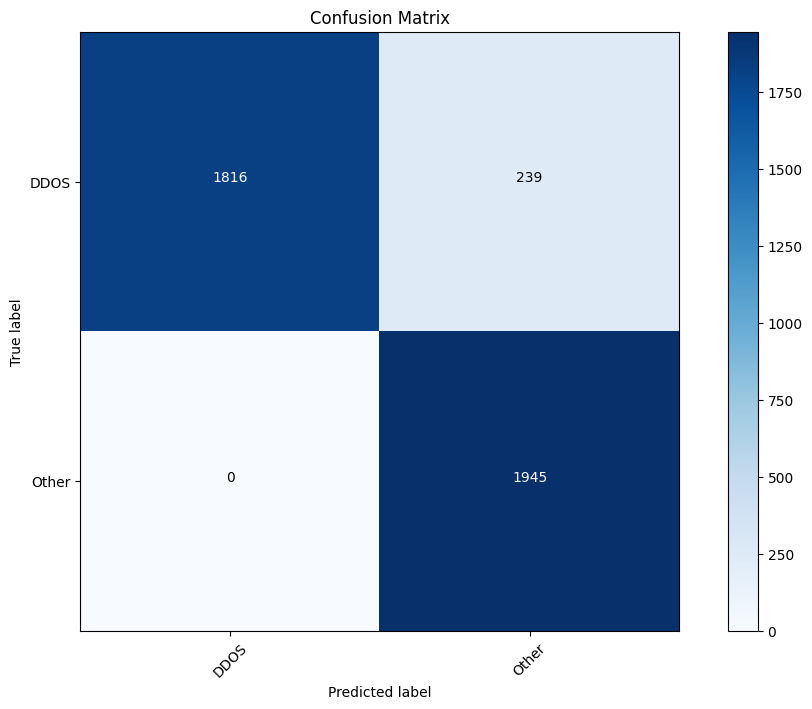

In [138]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Assuming your classes are named 'DDOS', 'Normal', and 'Other'
plot_confusion_matrix(cm, classes=['DDOS', 'Other'])

In [139]:
from sklearn.metrics import f1_score

f1 = f1_score(true, pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9421


In [ ]:
torch.save(model, 'ddos_cnn_model.pth')

### Crow Search Optimization

In [86]:
m=35  # Problem dimension (number of decision variables
Ap=0.2  # Awareness probability
fl=2   # Flight length (fl)
wf=1.2# wf is used to control the importance of classification accuracy and number of selected features.
d=48# Flock (population) size
lt=48

In [87]:
features=[i for i in range(0,lt)]
features[-1]

47

In [88]:
imo = pd.Series(df['category'])

In [89]:
def init():   #initialization function
    df2=pd.DataFrame(np.ones((m,d),dtype='int'),columns=features)
    return df2

In [90]:
def fitness(df2):      # fitness function whose 1 parameter takes the crows and their position as input
    fnt=np.zeros((m,1))  # fnt is the fitness function
    for k in range(m):    
        global sel
        sel=[]
        q=0
        imp=0
        a=(df2.iloc[k,:])==0.0
        if a.all()==True:
            df2.iloc[k,:]=1.0
        for p in features:
            if df2.loc[k,p]==1.0:
                sel.insert(q,p)
                temp=imo[p]
                imp=imp+temp
            q=q+1
        lf=len(sel)
        divide=lf/lt
        fnt[k]=imp+wf*(1-float(lf/lt))     # fitness formula
        del sel
    return fnt

In [91]:
z=init()   #crow memory with initial position
tmax=1 #   # Maximum number of iterations (itermax)
xn=z.copy()  # the position of the crow
mem=init()  # memory is initialized using the init function
xnew=(xn).copy()   # the positions of the crow
ft=fitness(xn)
plotit=[]

In [92]:
criterion = nn.BCELoss()

# Define optimizer for your neural network
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001)  

In [93]:
tottime=0
s=pd.DataFrame(z)
print("got s")    # it is a formula to convert positions of each crow into 0 and 1 
for t in range(tmax):
    print(t)# no of iterations
    time1=time.time()
   
    xnew_list = []
    plotit.insert(t,ft.max())
    num = random.randint(0,m-1)  
   # Generation of random candidate crows for following (chasing)
    for i in tqdm(range(m)):   
       
        r=random.random()
        if r>=Ap:
            
            xnew_list.append((xn.loc[i,:]+fl*r*(mem.loc[num,:]-xn.loc[i,:])).tolist())# Generation of a new position for crow i (state 1)
            
        else:
            
            xnew_list.append((xnew.loc[i,:].apply(lambda lam:random.random())).tolist())   # Generation of a new position for crow i (state 2)
            
            
    xnew = pd.DataFrame(xnew_list)
    del xnew_list
    print('transpose')
    xnew= 1/( 1 + np.expm1(( 10*(xnew-0.5 ) ) ))    #  formula to convert positions of each crow into 0 and 1
    print('exp')
    xnew=xnew.apply(lambda l:l>=random.random()).astype(int)
    print('apply lambda')
    xn=xnew.copy()     
    print('copied')
    # it is the updated binary position of each crow
    #feasibility test
    # this is done so that to check if atleast one position of the crow has value equal to 1. if it is not true then every
    # position value of the crow is made 1.
    for i in tqdm(range(m)):
        a=(xn.loc[i,:])==0.0
        if a.all()==True:
            xn.loc[i,:]=1.0
    print('running fitness')
    ft_new=fitness(xn).reshape(ft.shape)# here the accuracy of each crows are calculated.

    print('fitness done')
    for i in tqdm(range(m)):
        
        if ft_new[i]>ft[i]:
            ft[i]=ft_new[i]
            for j in features:
                mem.loc[i,j]= xn.loc[i,j]
    print('complete')
    time2=time.time()
    tottime=tottime+(time2-time1)
print(tottime/50)

got s
0


100%|██████████| 35/35 [00:00<00:00, 593.24it/s]


transpose
exp
apply lambda
copied


100%|██████████| 35/35 [00:00<00:00, 1129.11it/s]


running fitness
fitness done


100%|██████████| 35/35 [00:00<00:00, 507.30it/s]

complete
0.006940102577209473


In [94]:
model2 = Multiclass().to(device)

In [95]:
batch_size = 128  # Adjust batch size as needed
num_epochs = 5

In [96]:
df.shape

(668522, 46)

In [97]:
df_category_0 = df[df['category'] == 0]
df_category_1 = df[df['category'] == 1]

df_sample_0 = df_category_0.sample(n=10000, random_state=42)
df_sample_1 = df_category_1.sample(n=10000, random_state=42)

df2 = pd.concat([df_sample_0, df_sample_1])

# Shuffle the new DataFrame to randomize the order of rows
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)


In [98]:
epoch_accuracies = []
epoch_losses = []

for epoch in tqdm(range(num_epochs)):  # Define num_epochs
    total_loss = 0.0
    correct_predictions = 0
    
    for i in range(0, len(df2), batch_size): 
        batch_df = df2.iloc[i:i+batch_size]
        inputs = batch_df.drop(columns=['category']).values
        labels = batch_df['category'].values

        inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1).permute(0,2,1).to(device)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)

        
        # Crow Search Optimization
        optimizer.zero_grad()
        for t in range(tmax):
            time1 = time.time()
            
            xnew_list = []
            num = random.randint(0, m-1)
            for i in range(m):   
                r = random.random()
                if r >= Ap:
                    xnew_list.append((xn.loc[i, :] + fl * r * (mem.loc[num, :] - xn.loc[i, :])).tolist())
                else:
                    xnew_list.append((xnew.loc[i, :].apply(lambda lam: random.random())).tolist())
                    
            xnew = pd.DataFrame(xnew_list)
            del xnew_list
            xnew = 1 / (1 + np.expm1((10 * (xnew - 0.5))))
            xnew = xnew.apply(lambda l: l >= random.random()).astype(int)
            xn = xnew.copy()     
            
            for i in range(m):
                a = (xn.loc[i, :]) == 0.0
                if a.all() == True:
                    xn.loc[i, :] = 1.0
                    
            ft_new = fitness(xn).reshape(ft.shape)
            for i in range(m):
                if ft_new[i] > ft[i]:
                    ft[i] = ft_new[i]
                    for j in features:
                        mem.loc[i, j] = xn.loc[i, j]
            
            time2 = time.time()
            tottime = tottime + (time2 - time1)


        with torch.inference_mode():
            outputs = model2(inputs)
            #predictions = (torch.sigmoid(outputs) > 0.5).float()  # Convert probabilities to binary predictions
            outputs = torch.argmax(outputs, dim=1)
            loss = criterion(outputs.float(), labels)
            loss.backward()
            total_loss += loss.item()

        # Calculate accuracy
        correct_predictions += torch.sum(outputs == labels).item()

        # Calculate epoch accuracy and loss
        epoch_accuracy = correct_predictions / len(df2)
        epoch_loss = total_loss / (len(df2) / batch_size)
         
    # Append accuracy and loss to lists
    epoch_accuracies.append(epoch_accuracy)
    epoch_losses.append(epoch_loss)
    
    # Print accuracy and loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {epoch_accuracy}, Loss: {epoch_loss}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(48,) 0
(48,) 48


RuntimeError: shape '[16]' is invalid for input of size 0

In [58]:
torch.cuda.is_available()

False

In [100]:
def fitness(df2):
    fnt = np.zeros((m, 1))  # fnt is the fitness function
    for k in range(m):
        sel = []
        q = 0
        imp = 0
        a = (df2.iloc[k, :]) == 0.0
        if a.all() == True:
            df2.iloc[k, :] = 1.0
        for p in features:
            if df2.loc[k, p] == 1.0:
                sel.insert(q, p)
                temp = imo[p]
                imp = imp + temp
            q = q + 1
        lf = len(sel)
        divide = lf / lt
        fnt[k] = imp + wf * (1 - float(lf / lt))  # fitness formula
        del sel
    return fnt

### Actual implementation (3)

In [84]:
def initialize_population(population_size):
    # Generate random initial positions for crows
    return [np.random.uniform(low=-1.0, high=1.0, size=45) for _ in range(population_size)]

In [85]:
def update_positions(population, global_best_position, inertia_weight=0.5, exploration_rate=0.1):
    # Update positions of crows based on their previous positions and the global best position
    # Use some exploration strategy (e.g., randomization, inertia, etc.)
    updated_population = []
    for crow_position in population:
        # Calculate crow movement towards the global best position
        crow_movement = inertia_weight * (global_best_position - crow_position)
        
        # Add some randomness for exploration
        exploration = exploration_rate * np.random.uniform(-1, 1, size=crow_position.shape)
        
        # Update crow position
        new_crow_position = crow_position + crow_movement + exploration
        
        # Append the updated position to the list
        updated_population.append(new_crow_position)
    
    return updated_population

In [86]:
def update_model_parameters(model, crow_position):
    # Update model parameters based on crow position
    crow_position_tensor = torch.tensor(crow_position, dtype=torch.float32)

    # Total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters())

    # Iterate through model parameters and update them based on the crow position
    param_index = 0
    for param in model.parameters():
        if param_index >= 45:
            break  # Break the loop if all parameters have been updated
        # Calculate the number of elements in the parameter tensor
        num_elements = param.numel()
        print(f'prarm_idx: {param_index}, numel: {num_elements}')
        # Extract a slice of the crow position tensor with the same size as the parameter tensor
        param_update = crow_position_tensor[param_index:param_index+num_elements]

        # Reshape the parameter update to match the shape of the parameter tensor
        param_update = param_update.view(param.size())

        # Update the parameter tensor with the crow position values
        param.data = param_update

        # Move to the next position in the crow position tensor
        param_index += 15

        # Ensure param_index does not exceed the total number of parameters
        


In [105]:
def train_and_evaluate(model, data_loader, criterion, optimizer):
    # Train the model on the dataset and evaluate performance
    # Return performance metric (e.g., accuracy)
    model.train()

    # Iterate over the dataset in batches
    for inputs, labels in data_loader:
        # print(inputs.shape)
        # print(labels)
        
        # Forward pass
        inputs = inputs.unsqueeze(-1).permute(0,2,1)
        # print(inputs.shape)
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Evaluate the model on the entire dataset
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Forward pass
            inputs = inputs.unsqueeze(-1).permute(0,2,1)
            outputs = model(inputs)
            
            # Convert outputs and labels to numpy arrays
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Calculate evaluation metric (e.g., accuracy)
    accuracy = accuracy_score(targets, predictions)
    print("Accuracy:", accuracy)

    return accuracy

In [106]:
model3 = Multiclass()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [107]:
def evaluate_fitness(model, data, criterion, population):
    # Evaluate the fitness (performance metric) of each crow (solution)
    fitness_values = []
    for crow_position in population:
        # Update model parameters
        # print(model)
        update_model_parameters(model, crow_position)

        # Train the model and evaluate performance
        # Calculate accuracy or other performance metric
        accuracy = train_and_evaluate(model, data, criterion,optimizer)

        fitness_values.append(accuracy)  # Or any other performance metric

    return np.array(fitness_values)

In [108]:
def cso_optimization(population_size, max_iterations, model, data, criterion):
    # Initialize population randomly or using some strategy
    population = initialize_population(population_size)

    # Main optimization loop
    for iteration in range(max_iterations):
        # Evaluate fitness of each crow (solution)
        # print(population[1].shape)
        fitness_values = evaluate_fitness(model, data, criterion, population)

        # Update global best position
        global_best_index = np.argmax(fitness_values)
        global_best_position = population[global_best_index]
        print(global_best_position)

        # Update crow positions
        population = update_positions(population, global_best_position)

        # Update model parameters based on best solution found
        update_model_parameters(model, global_best_position)


In [109]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [110]:
data = data_loader # Your dataset
criterion = nn.CrossEntropyLoss()  

# Perform CSO optimization
cso_optimization(population_size=10, max_iterations=1, model=model3, data=data, criterion=criterion)

prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9952080740137879
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9942715315013405
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9972876172922251
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.996442335312141
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9959710719073152
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9958947721179625
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9958573702604366
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9961087107430103
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Accuracy: 0.9959246936039832
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
